<table border="0">
    <tr>
        <td>
            <img src="https://ictd2016.files.wordpress.com/2016/04/microsoft-research-logo-copy.jpg" style="width 30px;" />
             </td>
        <td>
            <img src="https://www.microsoft.com/en-us/research/wp-content/uploads/2016/12/MSR-ALICE-HeaderGraphic-1920x720_1-800x550.jpg" style="width 100px;"/></td>
        </tr>
</table>

# Dynamic Double Machine Learning: Use Cases and Examples

Dynamic DoubleML is an extension of the Double ML approach for treatments assigned sequentially over time periods. This estimator will account for treatments that can have causal effects on future outcomes. For more details, see [this paper](https://arxiv.org/abs/2002.07285) or the [EconML docummentation](https://econml.azurewebsites.net/).

For example, the Dynamic DoubleML could be useful in estimating the following causal effects:
* the effect of investments on revenue at companies that receive investments at regular intervals ([see more](https://arxiv.org/abs/2103.08390))
* the effect of prices on demand in stores where prices of goods change over time
* the effect of income on health outcomes in people who receive yearly income

The preferred data format is balanced panel data. Each panel corresponds to one entity (e.g. company, store or person) and the different rows in a panel correspond to different time points. Example:

||Company|Year|Features|Investment|Revenue|
|---|---|---|---|---|---|
|1|A|2018|...|\$1,000|\$10,000|
|2|A|2019|...|\$2,000|\$12,000|
|3|A|2020|...|\$3,000|\$15,000|
|4|B|2018|...|\$0|\$5,000|
|5|B|2019|...|\$100|\$10,000|
|6|B|2020|...|\$1,200|\$7,000|
|7|C|2018|...|\$1,000|\$20,000|
|8|C|2019|...|\$1,500|\$25,000|
|9|C|2020|...|\$500|\$15,000|

(Note: when passing the data to the DynamicDML estimator, the "Company" column above corresponds to the `groups` argument at fit time. The "Year" column above should not be passed in as it will be inferred from the "Company" column)

If group memebers do not appear together, it is assumed that the first instance of a group in the dataset corresponds to the first period of that group, the second instance of the group corresponds to the second period, etc. Example:

||Company|Features|Investment|Revenue|
|---|---|---|---|---|
|1|A|...|\$1,000|\$10,000|
|2|B|...|\$0|\$5,000
|3|C|...|\$1,000|\$20,000|
|4|A|...|\$2,000|\$12,000|
|5|B|...|\$100|\$10,000|
|6|C|...|\$1,500|\$25,000|
|7|A|...|\$3,000|\$15,000|
|8|B|...|\$1,200|\$7,000|
|9|C|...|\$500|\$15,000|

In this dataset, 1<sup>st</sup> row corresponds to the first period of group `A`, 4<sup>th</sup> row corresponds to the second period of group `A`, etc.

In this notebook, we show the performance of the DynamicDML on synthetic and observational data. 

## Notebook Contents

1. [Example Usage with Average Treatment Effects](#1.-Example-Usage-with-Average-Treatment-Effects)
2. [Example Usage with Heterogeneous Treatment Effects](#2.-Example-Usage-with-Heterogeneous-Treatment-Effects)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import econml

In [3]:
# Main imports
from econml.dynamic.dml import DynamicDML
from econml.tests.dgp import DynamicPanelDGP, add_vlines

# Helper imports
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, MultiTaskLassoCV
import matplotlib.pyplot as plt

%matplotlib inline

# 1. Example Usage with Average Treatment Effects

## 1.1 DGP

We consider a data generating process from a markovian treatment model. 

In the example bellow, $T_t\rightarrow$ treatment(s) at time $t$, $Y_t\rightarrow$outcome at time $t$, $X_t\rightarrow$ features and controls at time $t$ (the coefficients $e, f$ will pick the features and the controls).
\begin{align}
    X_t =& (\pi'X_{t-1} + 1) \cdot A\, T_{t-1} + B X_{t-1} + \epsilon_t\\
    T_t =& \gamma\, T_{t-1} + (1-\gamma) \cdot D X_t + \zeta_t\\
    Y_t =& (\sigma' X_{t} + 1) \cdot e\, T_{t} + f X_t + \eta_t
\end{align}

with $X_0, T_0 = 0$ and $\epsilon_t, \zeta_t, \eta_t \sim N(0, \sigma^2)$. Moreover, $X_t \in R^{n_x}$, $B[:, 0:s_x] \neq 0$ and $B[:, s_x:-1] = 0$, $\gamma\in [0, 1]$, $D[:, 0:s_x] \neq 0$, $D[:, s_x:-1]=0$, $f[0:s_x]\neq 0$, $f[s_x:-1]=0$. We draw a single time series of samples of length $n\_panels \cdot n\_periods$.

In [662]:
# Define DGP parameters
np.random.seed(123)
n_panels = 5000 # number of panels
n_periods = 2 # number of time periods in each panel
n_treatments = 1 # number of treatments in each period
n_x = 100 # number of features + controls
s_x = 10 # number of controls (endogeneous variables)
s_t = 10 # treatment support size

In [663]:
# Generate data
dgp = DynamicPanelDGP(n_periods, n_treatments, n_x).create_instance(
            s_x, random_seed=12345, autoreg=1.0)
Y, T, X, W, groups = dgp.observational_data(n_panels, s_t=s_t, random_seed=12345)
true_effect = dgp.true_effect

## 1.2 Train Estimator

In [664]:
est = DynamicDML(
    model_y=LassoCV(cv=3, max_iter=1000), 
    model_t=MultiTaskLassoCV(cv=3, max_iter=1000), 
    cv=3)

In [665]:
est.fit(Y, T, X=None, W=W, groups=groups)

In [666]:
# Average treatment effect of all periods on last period for unit treatments
print(f"Average effect of default policy: {est.ate():0.2f}")

Average effect of default policy: 0.88


In [667]:
# Effect of target policy over baseline policy
# Must specify a treatment for each period
baseline_policy = np.zeros((1, n_periods * n_treatments))
target_policy = np.ones((1, n_periods * n_treatments))
eff = est.effect(T0=baseline_policy, T1=target_policy)
print(f"Effect of target policy over baseline policy: {eff[0]:0.2f}")

Effect of target policy over baseline policy: 0.88


In [668]:
# Period treatment effects + interpretation
for i, theta in enumerate(est.intercept_.reshape(-1, n_treatments)):
    print(f"Marginal effect of a treatments in period {i+1} on period {n_periods} outcome: {theta}")

Marginal effect of a treatments in period 1 on period 2 outcome: [0.74685576]
Marginal effect of a treatments in period 2 on period 2 outcome: [0.13065877]


In [669]:
# Period treatment effects with confidence intervals
est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0)$_0$,0.747,0.022,34.58,0.0,0.711,0.782
cate_intercept|(T0)$_1$,0.131,0.001,89.995,0.0,0.128,0.133


In [670]:
conf_ints = est.intercept__interval(alpha=0.05)

## 1.3 Performance Visualization

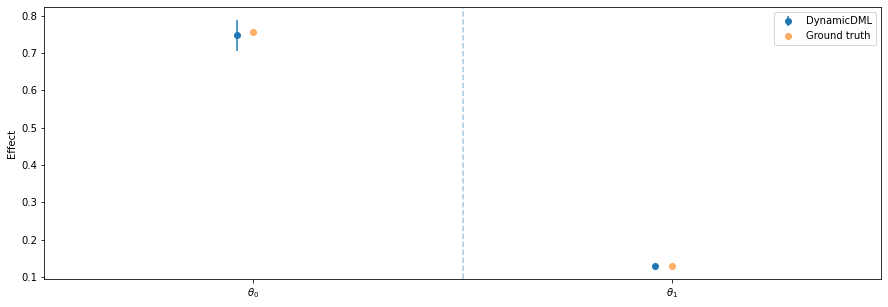

In [671]:
# Some plotting boilerplate code
plt.figure(figsize=(15, 5))
plt.errorbar(np.arange(n_periods*n_treatments)-.04, est.intercept_, yerr=(conf_ints[1] - est.intercept_,
                                                    est.intercept_ - conf_ints[0]), fmt='o', label='DynamicDML')
plt.errorbar(np.arange(n_periods*n_treatments), true_effect.flatten(), fmt='o', alpha=.6, label='Ground truth')
for t in np.arange(1, n_periods):
    plt.axvline(x=t * n_treatments - .5, linestyle='--', alpha=.4)
plt.xticks([t * n_treatments - .5 + n_treatments/2 for t in range(n_periods)],
           ["$\\theta_{}$".format(t) for t in range(n_periods)])
plt.gca().set_xlim([-.5, n_periods*n_treatments - .5])
plt.ylabel("Effect")
plt.legend()
plt.show()

# 2. Example Usage with Heterogeneous Treatment Effects on Time-Invariant Unit Characteristics

We can also estimate treatment effect heterogeneity with respect to the value of some subset of features $X$ in the initial period. Heterogeneity is currently only supported with respect to such initial state features. This for instance can support heterogeneity with respect to time-invariant unit characteristics. In that case you can simply pass as $X$ a repetition of some unit features that stay constant in all periods. You can also pass time-varying features, and their time varying component will be used as a time-varying control. However, heterogeneity will only be estimated with respect to the initial state.

## 2.1 DGP

In [672]:
# Define additional DGP parameters
het_strength = .5
het_inds = np.arange(n_x - n_treatments, n_x)

In [674]:
# Generate data
dgp = DynamicPanelDGP(n_periods, n_treatments, n_x).create_instance(
            s_x, hetero_strength=het_strength, hetero_inds=het_inds,
            autoreg=1.0, random_seed=1566)
Y, T, X, W, groups = dgp.observational_data(n_panels, s_t=s_t, random_seed=1)
ate_effect = dgp.true_effect
het_effect = dgp.true_hetero_effect[:, het_inds + 1]

## 2.2 Train Estimator

In [675]:
est = DynamicDML(
    model_y=LassoCV(cv=3), 
    model_t=MultiTaskLassoCV(cv=3),
    cv=3)

In [676]:
est.fit(Y, T, X=X, W=W, groups=groups, inference="auto")

In [677]:
est.summary()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0|(T0)$_0$,-0.195,0.024,-8.258,0.0,-0.234,-0.156
X0|(T0)$_1$,0.17,0.007,23.954,0.0,0.158,0.182
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0)$_0$,-0.686,0.019,-36.172,0.0,-0.717,-0.655
cate_intercept|(T0)$_1$,0.387,0.003,123.432,0.0,0.382,0.392


In [678]:
# Average treatment effect for test points
X_test = X[np.arange(0, 25, 3)]
print(f"Average effect of default policy:{est.ate(X=X_test):0.2f}")

Average effect of default policy:-0.30


In [679]:
# Effect of target policy over baseline policy
# Must specify a treatment for each period
baseline_policy = np.zeros((1, n_periods * n_treatments))
target_policy = np.ones((1, n_periods * n_treatments))
eff = est.effect(X=X_test, T0=baseline_policy, T1=target_policy)
print("Effect of target policy over baseline policy for test set:\n", eff)

Effect of target policy over baseline policy for test set:
 [-0.31313766 -0.28511487 -0.25212365 -0.28079434 -0.31669279 -0.29733827
 -0.31471126 -0.30720557 -0.31935427]


In [680]:
# Coefficients: intercept is of shape n_treatments*n_periods
# coef_ is of shape (n_treatments*n_periods, n_hetero_inds).
# first n_treatment rows are from first period, next n_treatment
# from second period, etc.
est.intercept_, est.coef_

(array([-0.68574484,  0.38678986]),
 array([[-0.19528374],
        [ 0.16988612]]))

In [681]:
# Confidence intervals
conf_ints_intercept = est.intercept__interval(alpha=0.05)
conf_ints_coef = est.coef__interval(alpha=0.05)

## 2.3 Performance Visualization

In [682]:
# parse true parameters in array of shape (n_treatments*n_periods, 1 + n_hetero_inds)
# first column is the intercept
true_effect_inds = []
for t in range(n_treatments):
    true_effect_inds += [t * (1 + n_x)] + (list(t * (1 + n_x) + 1 + het_inds) if len(het_inds)>0 else [])
true_effect_params = dgp.true_hetero_effect[:, true_effect_inds]
true_effect_params = true_effect_params.reshape((n_treatments*n_periods, 1 + het_inds.shape[0]))

In [683]:
# concatenating intercept and coef_
param_hat = np.hstack([est.intercept_.reshape(-1, 1), est.coef_])
lower = np.hstack([conf_ints_intercept[0].reshape(-1, 1), conf_ints_coef[0]])
upper = np.hstack([conf_ints_intercept[1].reshape(-1, 1), conf_ints_coef[1]])

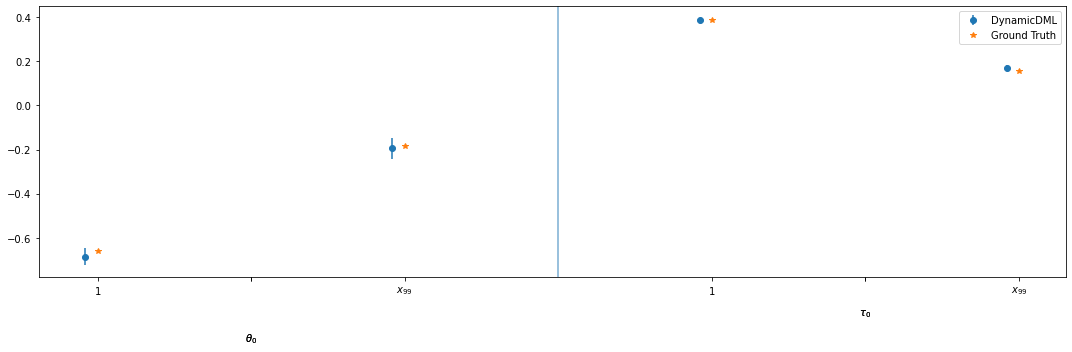

In [684]:
plt.figure(figsize=(15, 5))
plt.errorbar(np.arange(n_periods * (len(het_inds) + 1) * n_treatments) - .04,
             param_hat.flatten(), yerr=((upper - param_hat).flatten(),
                                        (param_hat - lower).flatten()), fmt='o', label='DynamicDML')
plt.errorbar(np.arange(n_periods * (len(het_inds) + 1) * n_treatments),
             true_effect_params.flatten(), fmt='*', label='Ground Truth')
add_vlines(n_periods, n_treatments, het_inds)
plt.legend()
plt.show()

In [685]:
est.nuisance_scores_t

[[array([[0.62796393,        nan],
         [0.02288447, 0.69411009]]),
  array([[0.62029796,        nan],
         [0.02398661, 0.70367478]]),
  array([[0.60836524,        nan],
         [0.03213052, 0.67573604]])]]

In [686]:
est.nuisance_scores_y

[[array([0.03746542, 0.95368997]),
  array([0.04434471, 0.95549658]),
  array([0.0488638 , 0.95356307])]]

# Job Corps Data

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, LogisticRegressionCV


df = pd.read_csv('JC.csv')
df = df.rename(columns={'Unnamed: 0':'id'}).reset_index().drop('index', axis=1).set_index(['id'])
df.head()

,assignment,female,age,white,black,hispanic,educ,educmis,geddegree,hsdegree,...,trainy1,trainy2,pworky2,pworky3,pworky4,earny2,earny3,earny4,health30,health48
id,,,,,,,,,,,,,,,,,,,,,
2,0,0,24,0,1,0,12,0,0,1,...,0,0,26.923077,86.538460,65.384613,63.387691,238.996002,265.188324,2,2
3,1,1,18,1,0,0,8,0,1,0,...,1,0,30.769230,26.923077,71.153847,95.603455,41.870399,216.835815,1,2
5,0,1,18,0,1,0,10,0,0,0,...,1,0,0.000000,36.538460,11.538462,0.000000,52.758656,11.856046,3,2
7,1,1,17,1,0,0,10,0,0,0,...,1,1,100.000000,32.692307,15.384615,285.628265,71.364548,18.296368,2,3
9,1,0,21,0,0,1,12,0,0,1,...,1,0,44.230770,96.153847,100.000000,86.732307,247.794205,221.147690,2,2


In [3]:
x0_cols = list(df.columns[1:29])
x1_cols = list(df.columns[29:36])
t0_cols = df.columns[[36]]
t1_cols = df.columns[[37]]
y_col = df.columns[43]

In [40]:
y = df[y_col]
X0 = df[x0_cols]
X1 = df[x1_cols]

In [60]:
panelX = np.zeros((X0.shape[0], 2, X0.shape[1] + X1.shape[1]))
panelX[:, 0, :X0.shape[1]] = X0.values
panelX[:, 1, :X0.shape[1]] = X0.values
panelX[:, 1, X0.shape[1]:] = X1.values

In [61]:
panelT = np.zeros((X0.shape[0], 2, 1))
panelT[:, 0, :] = df[t0_cols].values
panelT[:, 1, :] = df[t1_cols].values

In [62]:
lagpanelT = np.zeros((X0.shape[0], 2, 1))
lagpanelT[:, 1, :] = panelT[:, 0, :]

In [63]:
panelY = np.zeros((X0.shape[0], 2, 1))
panelY[:, 1, 0] = df[y_col].values

In [64]:
panelG = np.zeros((X0.shape[0], 2, 1), 'int')
panelG[:, 0, 0] = np.arange(X0.shape[0])
panelG[:, 1, 0] = np.arange(X0.shape[0])

In [65]:
def long(X):
    return X.reshape((-1, X.shape[-1]))

In [66]:
from econml.dynamic.dml import DynamicDML
est = DynamicDML(
    model_y=LassoCV(cv=3, max_iter=1000), 
    model_t=LogisticRegressionCV(cv=3, max_iter=2000),
    discrete_treatment=True,
    cv=3)

In [67]:
est.fit(long(panelY).flatten(), long(panelT).flatten(),
        W=np.hstack([long(panelX), long(lagpanelT)]),
        groups=long(panelG).flatten())

In [68]:
est.summary()

Coefficient Results:  X is None, please call intercept_inference to learn the constant!


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept|(T0_1.0)$_0$,18.43,4.51,4.087,0.0,11.012,25.849
cate_intercept|(T0_1.0)$_1$,22.059,4.224,5.222,0.0,15.111,29.008


In [70]:
est.effect_inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,40.49,4.988,8.117,0.0,32.285,48.695


# SNMM Algorithm

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Main imports
from econml.dynamic.dml import DynamicDML
from econml.tests.dgp import DynamicPanelDGP, add_vlines

# Helper imports
import numpy as np
from sklearn.linear_model import Lasso, LassoCV, LogisticRegression, LogisticRegressionCV, MultiTaskLassoCV
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LassoCV, LogisticRegressionCV

import warnings
warnings.simplefilter('ignore')

%matplotlib inline

### Real data

In [3]:
df = pd.read_csv('JC.csv')
df = df.rename(columns={'Unnamed: 0':'id'}).reset_index().drop('index', axis=1).set_index(['id'])
df.head()

,assignment,female,age,white,black,hispanic,educ,educmis,geddegree,hsdegree,...,trainy1,trainy2,pworky2,pworky3,pworky4,earny2,earny3,earny4,health30,health48
id,,,,,,,,,,,,,,,,,,,,,
2,0,0,24,0,1,0,12,0,0,1,...,0,0,26.923077,86.538460,65.384613,63.387691,238.996002,265.188324,2,2
3,1,1,18,1,0,0,8,0,1,0,...,1,0,30.769230,26.923077,71.153847,95.603455,41.870399,216.835815,1,2
5,0,1,18,0,1,0,10,0,0,0,...,1,0,0.000000,36.538460,11.538462,0.000000,52.758656,11.856046,3,2
7,1,1,17,1,0,0,10,0,0,0,...,1,1,100.000000,32.692307,15.384615,285.628265,71.364548,18.296368,2,3
9,1,0,21,0,0,1,12,0,0,1,...,1,0,44.230770,96.153847,100.000000,86.732307,247.794205,221.147690,2,2


In [4]:
x0_cols = list(df.columns[1:29])
x1_cols = list(df.columns[29:36])
t0_cols = df.columns[[36]]
t1_cols = df.columns[[37]]
y_col = df.columns[43]

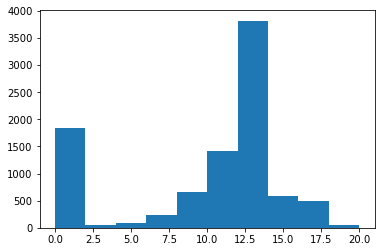

In [5]:
plt.hist(df['educmum'])
plt.show()

In [6]:
y = df[y_col].values
X = {0: df[x0_cols], 1: df[x1_cols], 'het': df[x0_cols]}
T = {0: df[t0_cols].values, 1: df[t1_cols].values}
m = 2

In [7]:
cat = ['age', 'educ', 'educmum', 'educdad']
X[0] = pd.get_dummies(X[0], columns=cat)
X[0] = pd.concat([X[0], df[cat]], axis=1)
x0_cols = list(X[0].columns)

In [16]:
true_effect_params = np.zeros((m, T[0].shape[1]))

### Simulated Data

In [8]:
from snmm import gen_data
m = 2
y, X, T, true_effect_params = gen_data(n_periods=m, n_units=10000, n_treatments=1,
                                       n_x=10, s_x=1, s_t=1,
                                       hetero_strenth=.0, n_hetero_vars=0, autoreg=1.0,
                                       instance_seed=13, sample_seed=1)

In [9]:
X['het'] = X[0]

In [61]:
true_effect_params

array([[[1.18717626]],

       [[0.22369918]]])

### Simulated data with heterogeneity

In [6]:
from snmm import gen_data
m = 2
y, X, T, true_effect_params = gen_data(n_periods=m, n_units=10000, n_treatments=1,
                                       n_x=10, s_x=1, s_t=1,
                                       hetero_strenth=.5, n_hetero_vars=1, autoreg=1.0,
                                       instance_seed=123, sample_seed=1)

In [10]:
true_effect_params

array([[[0.88288977, 0.45027826]],

       [[0.81068315, 0.32122891]]])

# Analysis

In [8]:
from snmm import get_linear_model_reg, get_linear_multimodel_reg
from snmm import get_model_reg, get_multimodel_reg
from snmm import get_poly_model_reg, get_poly_multimodel_reg
from econml.utilities import cross_product

### Define Model Parameters

In [57]:
# model_reg_fn = lambda X, y: get_model_reg(X, y, degrees=[1])
# multimodel_reg_fn = lambda X, y: get_multimodel_reg(X, y, degrees=[1])
# model_reg_fn = get_linear_model_reg
# multimodel_reg_fn = get_linear_multimodel_reg
model_reg_fn = lambda X, y: get_poly_model_reg(X, y, degree=1, interaction_only=True)
multimodel_reg_fn = lambda X, y: get_poly_multimodel_reg(X, y, degree=1, interaction_only=True)

In [58]:
het_cols11 = list(X[1].columns)
het_cols10 = list(X[0].columns)
het_cols0 = list(X[0].columns)
def phi(t, X, T, Tt):
    if t == 1:
        return np.hstack([Tt,
                          cross_product(Tt, T[t-1]),
                          cross_product(Tt, X[t][het_cols11].values),
                          cross_product(Tt, X[t-1][het_cols10].values),
                          cross_product(Tt, T[t-1], X[t][het_cols11].values),
                          cross_product(Tt, T[t-1], X[t-1][het_cols10].values)
                         ])
    elif t==0:
        return np.hstack([Tt, cross_product(Tt, X[t][het_cols0].values)])
    raise AttributeError("Not valid")

def phi_names(t):
    if t == 1:
        return ([f't2[{x}]' for x in range(T[1].shape[1])] +
                [f't2[{x}]*t1[{y}]' for y in range(T[0].shape[1]) for x in range(T[1].shape[1])] +
                [f't2[{x}]*x2[{y}]' for y in het_cols11 for x in range(T[1].shape[1])] + 
                [f't2[{x}]*x1[{y}]' for y in het_cols10 for x in range(T[1].shape[1])] +
                [f't2[{x}]*t1[{y}]*{z}' for z in het_cols11 for y in range(T[0].shape[1])
                                        for x in range(T[1].shape[1])] + 
                [f't2[{x}]*t1[{y}]*{z}' for z in het_cols10 for y in range(T[0].shape[1])
                                        for x in range(T[1].shape[1])]
               )
    elif t == 0:
        return ([f't1[{x}]' for x in range(T[1].shape[1])] + 
                [f't1[{x}]*{y}' for y in het_cols0 for x in range(T[1].shape[1])])
    raise AttributeError("Not valid")

def pi(t, X, T):
    return np.ones(T[t].shape)

### Estimate High-Dimensional Linear Blip Model

In [59]:
from snmm import SNMMDynamicDML

est = SNMMDynamicDML(m=m, phi=phi, phi_names_fn=phi_names,
                     model_reg_fn=model_reg_fn,
                     model_final_fn=lambda: LassoCV())

In [60]:
est.fit(X, T, y, pi)

Info set: 0
r2score_y 0.08334933610641171
Treatment: 0
r2score_Qjt[0] 0.04802599600821311
r2score_Qjt[1] 0.6027151607948683
r2score_Qjt[2] 0.6052099896332823
r2score_Qjt[3] 0.5815053230717475
r2score_Qjt[4] 0.6837854359299849
r2score_Qjt[5] 0.5279091454968388
r2score_Qjt[6] 0.5888321018821192
r2score_Qjt[7] 0.5764625902661078
r2score_Qjt[8] 0.29686818939522275
r2score_Qjt[9] 0.5974391026118071
r2score_Qjt[10] 0.5974671207679
r2score_Qjt[11] 0.707532384937431
r2score_Qjt[12] 0.6494087097360998
r2score_Qjt[13] 0.43186991799590535
r2score_Qjt[14] 0.5295812840912042
r2score_Qjt[15] 0.6385142452780457
r2score_Qjt[16] 0.5976138477109296
r2score_Qjt[17] 0.4524834754206949
r2score_Qjt[18] 0.6689439923630682
r2score_Qjt[19] 0.29934230565885644
r2score_Qjt[20] 0.5207209612600865
r2score_Qjt[21] 0.6323315109545582
r2score_Qjt[22] 0.5850560183626328
r2score_Qjt[23] 0.5569520763172588
r2score_Qjt[24] 0.6099272872628245
r2score_Qjt[25] 0.8008872271340539
r2score_Qjt[26] 0.736430961516146
r2score_Qjt

r2score_Qjt[137] 0.288315029447216
r2score_Qjt[138] 0.27695906693944394
r2score_Qjt[139] 0.2502929268592312
r2score_Qjt[140] 0.24162087337206883
r2score_Qjt[141] 0.2621249684576954
r2score_Qjt[142] 0.23358397122145846
r2score_Qjt[143] 0.28672450251065684
r2score_Qjt[144] 0.22455537327331176
r2score_Qjt[145] 0.21256074401937897
r2score_Qjt[146] 0.41705012440937783
r2score_Qjt[147] nan
r2score_Qjt[148] nan
r2score_Qjt[149] nan
r2score_Qjt[150] 0.24977860125691453
r2score_Qjt[151] 0.2988590520680876
r2score_Qjt[152] 0.2669245326626978
r2score_Qjt[153] 0.2560852281302476
r2score_Qjt[154] 0.2585087168897534
r2score_Qjt[155] 0.2669851399847285
r2score_Qjt[156] 0.21546891121322942
r2score_Qjt[157] 0.21033086028490589
r2score_Qjt[158] 0.24575908615972242
r2score_Qjt[159] -0.03247725399170576
r2score_Qjt[160] nan
r2score_Qjt[161] nan
r2score_Qjt[162] 0.23632501335061973
r2score_Qjt[163] -0.021884240377441078
r2score_Qjt[164] 0.02774528046242153
r2score_Qjt[165] 0.1391607058735037
r2score_Qjt[16

r2score_Qjt[159] 0.4922552494271919
r2score_Qjt[160] -0.0002164972937979126
r2score_Qjt[161] -0.00010823693040662441
r2score_Qjt[162] 0.39927074829692744
r2score_Qjt[163] -0.0023272141532229007
r2score_Qjt[164] 0.5212119429093671
r2score_Qjt[165] 0.4371030873745152
r2score_Qjt[166] 0.5537439547255225
r2score_Qjt[167] 0.4880243888076814
r2score_Qjt[168] 0.4750353259827679
r2score_Qjt[169] 0.397376925787832
r2score_Qjt[170] 0.39768273463657655
r2score_Qjt[171] 0.40566932725836824
r2score_Qjt[172] 0.3776622944563188
r2score_Qjt[173] 0.3981298887014002
r2score_Qjt[174] 0.38189277398879895
r2score_Qjt[175] 0.4356251503808245
r2score_Qjt[176] 0.4378581530742305
r2score_Qjt[177] 0.5624064830586897
r2score_Qjt[178] 0.43683067462530334
r2score_Qjt[179] 0.2919319707315845
r2score_Qjt[180] 0.2697362751983635
r2score_Qjt[181] 0.5766408139989008
r2score_Qjt[182] 0.40739786086214036
r2score_Qjt[183] 0.39624778951321726
r2score_Qjt[184] 0.22000229841606955
r2score_Qjt[185] 0.46487983919793285
r2score

In [61]:
print(est.policy_value_)

(221.57430270872447, 3.2413373283635276)


In [62]:
sig = {}
for t in range(m):
    print(f'Period {t} effects {true_effect_params[t]}')
    with pd.option_context("precision", 3):
        sig[t] = np.abs(est.psi_[t]) > 0.01
        display(est.param_summary(t, coef_thr=0.01).summary_frame())

Period 0 effects [0.]


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
t1[0]*mwearn,0.019,0.117,0.162,0.871,-0.174,0.212
t1[0]*age,0.811,27.263,0.030,0.976,-44.032,45.655


Period 1 effects [0.]


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
t2[0]*x2[earnq4],0.038,0.137,0.279,0.780,-0.188,0.264
t2[0]*x1[mwearn],0.081,0.081,0.994,0.320,-0.053,0.214
t2[0]*x1[age],0.801,16.426,0.049,0.961,-26.217,27.820
t2[0]*t1[0]*earnq4,-0.039,0.137,-0.283,0.777,-0.264,0.187
t2[0]*t1[0]*pworky1,-0.074,0.401,-0.185,0.853,-0.734,0.585
t2[0*t10*mwearn,0.075,0.104,0.721,0.471,-0.096,0.247


### Post Selection Inference (not unbiased): Low Dimensional Blip Model

In [63]:
def phi_sub(t, X, T, Tt):
    return phi(t, X, T, Tt)[:, sig[t]]

def phi_names_sub(t):
    return np.array(phi_names(t))[sig[t]]

In [64]:
from sklearn.linear_model import LinearRegression

est_sub = SNMMDynamicDML(m=m, phi=phi_sub, phi_names_fn=phi_names_sub,
                         model_reg_fn=lambda X, y: get_model_reg(X, y, degrees=[1]),
                         model_final_fn=lambda: LinearRegression())

In [ ]:
est_sub.fit(X, T, y, pi)

Info set: 0
r2score_y 0.0829682916963187
Treatment: 0
r2score_Qjt[0] 0.6492675525205862
r2score_Qjt[1] 0.021110672573726563
Treatment: 1
r2score_Qjt[0] 0.06768939329597345
r2score_Qjt[1] 0.4949255264452219
r2score_Qjt[2] 0.07254934238655486
r2score_Qjt[3] 0.01772351088664581
r2score_Qjt[4] 0.010684422681502936
r2score_Qjt[5] 0.2617099511775176
Info set: 1
r2score_y 0.12929622968264798
Treatment: 1
r2score_Qjt[0] 0.2868251488041934
r2score_Qjt[1] 0.4557269491560417
r2score_Qjt[2] 0.14155667202906397


In [ ]:
print(est_sub.policy_value_)

In [ ]:
for t in range(m):
    print(f'Period {t} effects {true_effect_params[t]}')
    with pd.option_context("precision", 3):
        display(est_sub.param_summary(t).summary_frame())

### Policy Delta compared to all zero

For simple phi, where the structural parameters don't change dependent on the target, we can do sth very simple

In [ ]:
print(est_sub.policy_delta_simple_)

### For complex phi we need to re-run the estimation for base

In [ ]:
est_sub.fit_base()

In [ ]:
deltapi, deltapierr = est_sub.policy_delta_complex()

In [ ]:
print(deltapi, deltapierr)

### Optimal Dynamic Policy

In [ ]:
est_sub.fit_opt(X, T, y)

In [ ]:
print(est_sub.opt_policy_delta_simple_)

In [ ]:
print(est_sub.opt_policy_delta_complex())

In [ ]:
for t in range(m):
    print(f'Period {t} effects {true_effect_params[t]}')
    with pd.option_context("precision", 3):
        display(est_sub.opt_param_summary(t).summary_frame())

# Non-Parametric Heterogeneity

In [32]:
# model_reg_fn = lambda X, y: get_model_reg(X, y, degrees=[1])
# multimodel_reg_fn = lambda X, y: get_multimodel_reg(X, y, degrees=[1])
# model_reg_fn = get_linear_model_reg
# multimodel_reg_fn = get_linear_multimodel_reg
model_reg_fn = lambda X, y: get_poly_model_reg(X, y, degree=1, interaction_only=False)
multimodel_reg_fn = lambda X, y: get_poly_multimodel_reg(X, y, degree=1, interaction_only=True)

In [33]:
def phi(t, X, T, Tt):
    if t == 1:
        return np.hstack([Tt, cross_product(Tt, T[t-1])])
    elif t==0:
        return np.hstack([Tt])
    raise AttributeError("Not valid")

def phi_names(t):
    if t == 1:
        return ([f't2[{x}]' for x in range(T[1].shape[1])] +
                [f't2[{x}]*t1[{y}]' for y in range(T[0].shape[1]) for x in range(T[1].shape[1])])
    elif t == 0:
        return [f't1[{x}]' for x in range(T[1].shape[1])]
    raise AttributeError("Not valid")

def pi(t, X, T):
    return np.ones(T[t].shape)

In [34]:
from snmm import fit_heterogeneous_final, LinearModelFinal
from econml.grf import CausalForest
from sklearn.linear_model import LinearRegression
from econml.sklearn_extensions.linear_model import StatsModelsLinearRegression

cf_gen = lambda: CausalForest(n_estimators=1000,
                              max_depth=3,
                              min_samples_leaf=50,
                              min_var_fraction_leaf=0.1,
                              min_var_leaf_on_val=True)

In [35]:
from snmm import HeteroSNMMDynamicDML

het_est = HeteroSNMMDynamicDML(m=m, phi=phi, phi_names_fn=phi_names,
                               model_reg_fn=lambda X, y: get_model_reg(X, y, degrees=[1]),
                               model_final_fn=cf_gen)

In [36]:
het_est.fit(X, T, y, pi)

Info set: 0
r2score_y 0.0829682916963187
Treatment: 0
r2score_Qjt[0] 0.049637293496599066
Treatment: 1
r2score_Qjt[0] 0.03845978836274733
r2score_Qjt[1] 0.004596208664351176
Info set: 1
r2score_y 0.12929622968264798
Treatment: 1
r2score_Qjt[0] 0.1484579584993989
r2score_Qjt[1] 0.32928847449388166


In [37]:
print(het_est.policy_value_)

(224.64026100365328, 4.256066341504719)


In [38]:
print(het_est.policy_delta_simple_)

(40.2300764746757, 8.394883749979765)


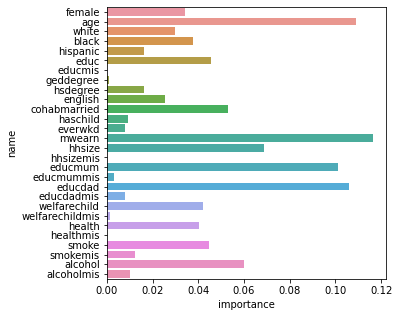

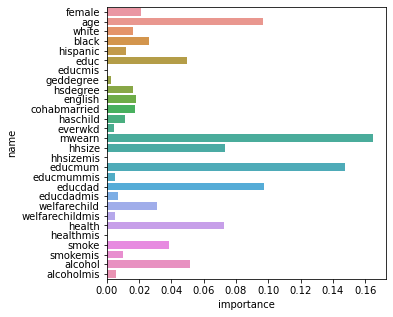

In [39]:
import seaborn as sns
if hasattr(het_est.models_[0], 'feature_importances_'):
    for t in range(m):
        impdf = het_est.feature_importances_(t)
        plt.figure(figsize=(5, 5))
        sns.barplot(y=impdf['name'], x=impdf['importance'])
        plt.show()

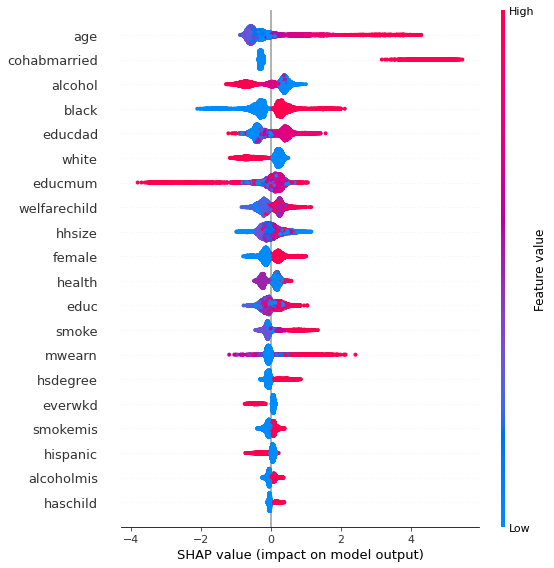

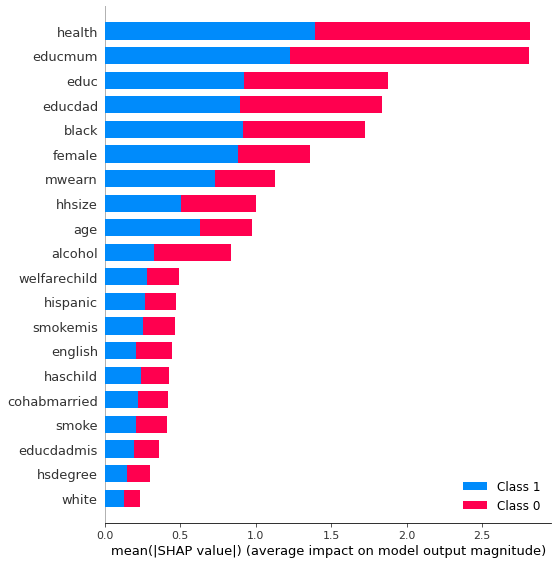

In [40]:
import shap
if hasattr(het_est.models_[0], 'feature_importances_'):
    for t in range(m):
        exp = shap.Explainer(het_est.models_[t])
        shap_values = exp.shap_values(X['het'])
        shap.summary_plot(shap_values, X['het'])

### Fit value of baseline policy, for delta estimation

In [205]:
het_est.fit_base()

Info set: 0
model_y: Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('sc', StandardScaler()),
                ('ls', Lasso(alpha=0.02991421408528289))])
r2score_y 0.019178024291191087
Treatment: 0
model_Qjt[0]: Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('sc', StandardScaler()),
                ('ls', Lasso(alpha=0.00651756134560545))])
r2score_Qjt[0] 0.9399206888468453
Treatment: 1
model_Qjt[0]: Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('sc', StandardScaler()),
                ('ls', Lasso(alpha=0.020948299622714328))])
r2score_Qjt[0] 0.029506487910945123
Info set: 1
model_y: Pipeline(steps=[('poly', PolynomialFeatures(degree=1, include_bias=False)),
                ('sc', StandardScaler()),
                ('ls', Lasso(alpha=0.018986811750133677))])
r2score_y 0.9271958530771578
Treatment: 1
model_Qjt[0]: Pipeline(steps=[('poly', PolynomialFe

In [206]:
print(het_est.policy_delta_complex())

(0.014049487193494222, 0.1257650517802176)


### Optimal Dynamic Policy

In [41]:
het_est.fit_opt(X, T, y)

Info set: 1
Treatment: 1
r2score_Qjt[0] 0.14842585443480238
r2score_Qjt[1] 0.32915567691338377
Info set: 0
Treatment: 0
r2score_Qjt[0] 0.049637293496599066
Treatment: 1
r2score_Qjt[0] 0.03828985822380915
r2score_Qjt[1] 0.004027405049432997


In [42]:
het_est.pi_star(1, X, T)[:10]

array([[1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]], dtype=int64)

In [43]:
if hasattr(het_est.models_[0], 'linear_model'):
    for t in range(m):
        print(f'Period {t} effects {true_effect_params[t]}')
        display(het_est.opt_param_summary(t).summary_frame())

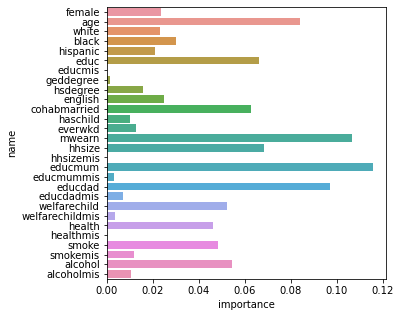

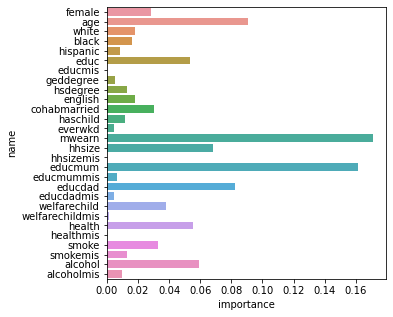

In [44]:
import seaborn as sns
if hasattr(het_est.opt_models_[0], 'feature_importances_'):
    for t in range(m):
        impdf = het_est.opt_feature_importances_(t)
        plt.figure(figsize=(5, 5))
        sns.barplot(y=impdf['name'], x=impdf['importance'])
        plt.show()

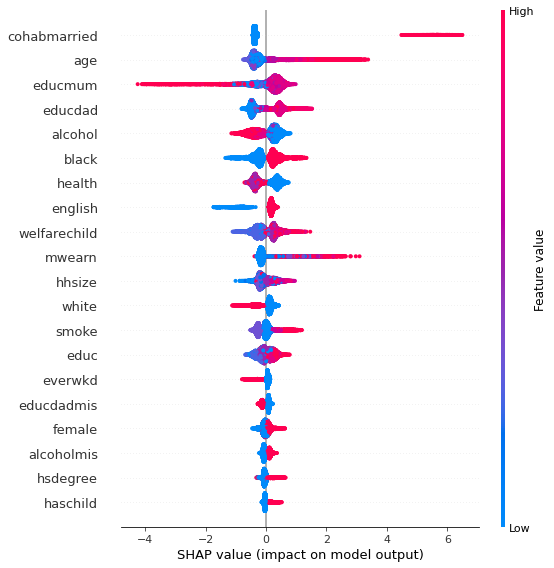

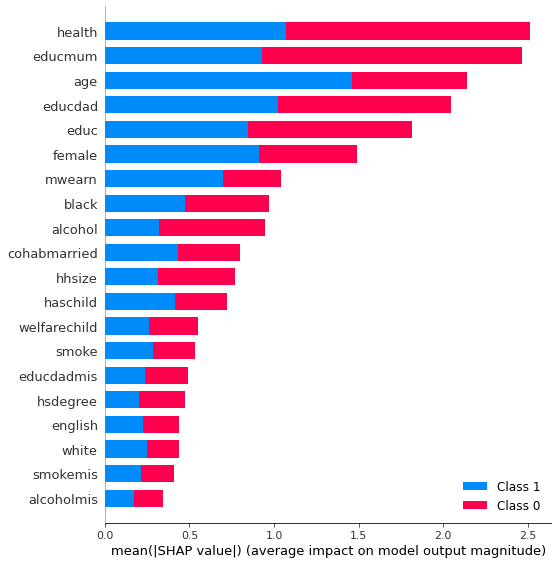

In [45]:
import shap
if hasattr(het_est.opt_models_[0], 'feature_importances_'):
    for t in range(m):
        exp = shap.Explainer(het_est.opt_models_[t])
        shap_values = exp.shap_values(X['het'])
        shap.summary_plot(shap_values, X['het'])

In [46]:
print(het_est.opt_policy_value_)

(224.99619668984099, 4.401483786083284)


In [47]:
print(het_est.opt_policy_delta_simple_)

(41.61272339840795, 8.768344682691867)


In [ ]:
print(het_est.opt_policy_delta_complex())

### Linear model of heterogeneity

In [54]:
# linear_gen = lambda: LinearModelFinal(StatsModelsLinearRegression(fit_intercept=False),
#                                       lambda x: x)
linear_gen = lambda: LinearModelFinal(LassoCV(fit_intercept=False),
                                  lambda x: x)
het_est.model_final_fn = linear_gen

In [55]:
het_est.fit_final()

In [56]:
if hasattr(het_est.models_[0], 'linear_model'):
    for t in range(m):
        print(f'Period {t} effects {true_effect_params[t]}')
        display(het_est.param_summary(t).summary_frame())

Period 0 effects [0.]


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
t1[0]*1,0.000,0.0,NaN,NaN,0.000,0.000
t1[0]*female,0.000,0.0,NaN,NaN,0.000,0.000
t1[0]*age,1.088,0.0,inf,0.0,1.088,1.088
t1[0]*white,-0.000,0.0,NaN,NaN,-0.000,-0.000
t1[0]*black,0.000,0.0,NaN,NaN,0.000,0.000
t1[0]*hispanic,-0.000,0.0,NaN,NaN,-0.000,-0.000
t1[0]*educ,0.000,0.0,NaN,NaN,0.000,0.000
t1[0]*educmis,-0.000,0.0,NaN,NaN,-0.000,-0.000
t1[0]*geddegree,-0.000,0.0,NaN,NaN,-0.000,-0.000


Period 1 effects [0.]


,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
t2[0]*1,0.000,0.0,NaN,NaN,0.000,0.000
t2[0]*t1[0]*1,-0.000,0.0,NaN,NaN,-0.000,-0.000
t2[0]*female,-0.000,0.0,NaN,NaN,-0.000,-0.000
t2[0]*t1[0]*female,-0.000,0.0,NaN,NaN,-0.000,-0.000
t2[0]*age,0.936,0.0,inf,0.0,0.936,0.936
t2[0]*t1[0]*age,0.000,0.0,NaN,NaN,0.000,0.000
t2[0]*white,0.000,0.0,NaN,NaN,0.000,0.000
t2[0]*t1[0]*white,-0.000,0.0,NaN,NaN,-0.000,-0.000
t2[0]*black,0.000,0.0,NaN,NaN,0.000,0.000
